## 1. Import Modules and Data

In [4]:
from data import mnist_dataloader, cifar10_dataloader
from modules import DCGAN
import torch
from torch import nn
import config
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import os
import math
import matplotlib.pyplot as plt
import numpy as np

sample_mnist_dir = os.path.join(config.sample_mnist_dir, "dcgan")
sample_cifar10_dir = os.path.join(config.sample_cifar10_dir, "dcgan")

os.makedirs(sample_mnist_dir, exist_ok=True)
os.makedirs(sample_cifar10_dir, exist_ok=True)

config.device


device(type='cuda', index=0)

## 2. Build Model

In [5]:
model = DCGAN(
    z_dim=config.z_dim,
    n_channel=1,  # Output size for MNIST (28x28)
    gen_hidden_dims=[512, 256, 128],
    gen_kernel_size=[4, 3, 4, 4],
    gen_stride=[1, 2, 2, 2],
    gen_padding=[0, 1, 1, 1],
    disc_hidden_dims=[128, 256, 512],
    disc_kernel_size=[4, 4, 3, 4],
    disc_stride=[2, 2, 2, 1],
    disc_padding=[1, 1, 1, 0],
    leaky_relu_slope=config.leaky_relu_slope,
    device=config.device,
)

model2 = DCGAN(
    z_dim=config.z_dim,
    n_channel=3,  # Output size for MNIST (28x28)
    gen_hidden_dims=[512, 256, 128],
    gen_kernel_size=[4, 4, 4, 4],
    gen_stride=[1, 2, 2, 2],
    gen_padding=[0, 1, 1, 1],
    disc_hidden_dims=[128, 256, 512],
    disc_kernel_size=[4, 4, 4, 4],
    disc_stride=[2, 2, 2, 1],
    disc_padding=[1, 1, 1, 0],
    leaky_relu_slope=config.leaky_relu_slope,
    device=config.device,
)

## 3. Train Model
We train the model on MNIST.

In [7]:
def train(model, dataloader, sample_dir, epoch):
    criterion = nn.BCELoss()
    optim_G = torch.optim.Adam(
        model.generator.parameters(), lr=config.gen_lr, betas=config.betas
    )
    optim_D = torch.optim.Adam(
        model.discriminator.parameters(), lr=config.disc_lr, betas=config.betas
    )
    d_losses = []
    g_losses = []

    for real_images, _ in tqdm(dataloader, desc=f"Training epoch {epoch + 1}"):
        batch_size = real_images.shape[0]
        real_images = real_images.to(config.device)
        real_labels = torch.ones(batch_size).to(config.device)
        fake_labels = torch.zeros(batch_size).to(config.device)

        # Train Discriminator
        optim_D.zero_grad()
        outputs = model.discriminate(real_images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, config.z_dim, 1, 1, device=config.device)
        fake_images = model.generate(z)
        outputs = model.discriminate(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optim_D.step()

        # Train Generator
        optim_G.zero_grad()
        outputs = model.discriminate(fake_images)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        optim_G.step()

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    # Save generated images every sample_interval epoch
    if (epoch + 1) % config.sample_interval == 0:
        with torch.no_grad():
            fake_images = model.generate(
                torch.randn(
                    config.num_samples, config.z_dim, 1, 1, device=config.device
                )
            )  # Generate num_samples images
            save_image(
                fake_images,
                os.path.join(sample_dir, f"generated_images_epoch_{epoch+1}.png"),
                nrow=int(math.sqrt(config.num_samples)),
                normalize=True,
            )

    return sum(d_losses) / len(d_losses), sum(g_losses) / len(g_losses)

In [4]:
print("Train on MNIST dataset...")
for epoch in range(config.epochs):
    avg_d_loss, avg_g_loss = train(model, mnist_dataloader, sample_mnist_dir, epoch)
    print(
        f"Epoch {epoch+1}/{config.epochs} Average Loss D: {avg_d_loss:.4f}, Average Loss G: {avg_g_loss:.4f}"
    )

model.save(os.path.join(config.ckpt_mnist_dir, "dcgan.pth"))

Train on MNIST dataset...


Training epoch 1: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]


Epoch 1/20 Average Loss D: 0.8183, Average Loss G: 3.2942


Training epoch 2: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]


Epoch 2/20 Average Loss D: 1.1741, Average Loss G: 1.1723


Training epoch 3: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]


Epoch 3/20 Average Loss D: 1.2606, Average Loss G: 0.9759


Training epoch 4: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]


Epoch 4/20 Average Loss D: 1.2594, Average Loss G: 0.9832


Training epoch 5: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]


Epoch 5/20 Average Loss D: 1.2716, Average Loss G: 0.9659


Training epoch 6: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]


Epoch 6/20 Average Loss D: 1.2739, Average Loss G: 0.9611


Training epoch 7: 100%|██████████| 469/469 [00:16<00:00, 28.13it/s]


Epoch 7/20 Average Loss D: 1.2716, Average Loss G: 0.9632


Training epoch 8: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]


Epoch 8/20 Average Loss D: 1.2642, Average Loss G: 0.9762


Training epoch 9: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]


Epoch 9/20 Average Loss D: 1.2567, Average Loss G: 0.9921


Training epoch 10: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]


Epoch 10/20 Average Loss D: 1.2497, Average Loss G: 1.0007


Training epoch 11: 100%|██████████| 469/469 [00:16<00:00, 28.49it/s]


Epoch 11/20 Average Loss D: 1.2411, Average Loss G: 1.0084


Training epoch 12: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]


Epoch 12/20 Average Loss D: 1.2329, Average Loss G: 1.0237


Training epoch 13: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]


Epoch 13/20 Average Loss D: 1.2245, Average Loss G: 1.0306


Training epoch 14: 100%|██████████| 469/469 [00:17<00:00, 27.54it/s]


Epoch 14/20 Average Loss D: 1.2197, Average Loss G: 1.0428


Training epoch 15: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]


Epoch 15/20 Average Loss D: 1.2111, Average Loss G: 1.0533


Training epoch 16: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]


Epoch 16/20 Average Loss D: 1.2064, Average Loss G: 1.0620


Training epoch 17: 100%|██████████| 469/469 [00:16<00:00, 28.07it/s]


Epoch 17/20 Average Loss D: 1.1989, Average Loss G: 1.0754


Training epoch 18: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]


Epoch 18/20 Average Loss D: 1.1958, Average Loss G: 1.0814


Training epoch 19: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]


Epoch 19/20 Average Loss D: 1.1889, Average Loss G: 1.0932


Training epoch 20: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]


Epoch 20/20 Average Loss D: 1.1832, Average Loss G: 1.0995


In [8]:
print("Train on CIFAR10 dataset...")
for epoch in range(config.epochs):
    avg_d_loss, avg_g_loss = train(
        model2, cifar10_dataloader, sample_cifar10_dir, epoch
    )
    print(
        f"Epoch {epoch+1}/{config.epochs} Average Loss D: {avg_d_loss:.4f}, Average Loss G: {avg_g_loss:.4f}"
    )

model2.save(os.path.join(config.ckpt_cifar10_dir, "dcgan.pth"))

Train on CIFAR10 dataset...


Training epoch 1: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]


Epoch 1/30 Average Loss D: 0.4364, Average Loss G: 6.8947


Training epoch 2: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]


Epoch 2/30 Average Loss D: 0.4996, Average Loss G: 4.8244


Training epoch 3: 100%|██████████| 391/391 [00:19<00:00, 20.56it/s]


Epoch 3/30 Average Loss D: 0.6382, Average Loss G: 3.8848


Training epoch 4: 100%|██████████| 391/391 [00:20<00:00, 19.33it/s]


Epoch 4/30 Average Loss D: 0.5145, Average Loss G: 3.8233


Training epoch 5: 100%|██████████| 391/391 [00:20<00:00, 19.36it/s]


Epoch 5/30 Average Loss D: 0.5433, Average Loss G: 3.6488


Training epoch 6: 100%|██████████| 391/391 [00:20<00:00, 19.53it/s]


Epoch 6/30 Average Loss D: 0.6270, Average Loss G: 3.2858


Training epoch 7: 100%|██████████| 391/391 [00:20<00:00, 19.45it/s]


Epoch 7/30 Average Loss D: 0.6887, Average Loss G: 2.9127


Training epoch 8: 100%|██████████| 391/391 [00:20<00:00, 19.49it/s]


Epoch 8/30 Average Loss D: 0.7406, Average Loss G: 2.7170


Training epoch 9: 100%|██████████| 391/391 [00:19<00:00, 19.69it/s]


Epoch 9/30 Average Loss D: 0.7387, Average Loss G: 2.5865


Training epoch 10: 100%|██████████| 391/391 [00:19<00:00, 19.60it/s]


Epoch 10/30 Average Loss D: 0.7187, Average Loss G: 2.6729


Training epoch 11: 100%|██████████| 391/391 [00:19<00:00, 19.64it/s]


Epoch 11/30 Average Loss D: 0.6964, Average Loss G: 2.7032


Training epoch 12: 100%|██████████| 391/391 [00:20<00:00, 19.50it/s]


Epoch 12/30 Average Loss D: 0.7195, Average Loss G: 2.6029


Training epoch 13: 100%|██████████| 391/391 [00:19<00:00, 19.84it/s]


Epoch 13/30 Average Loss D: 0.7355, Average Loss G: 2.4543


Training epoch 14: 100%|██████████| 391/391 [00:19<00:00, 19.72it/s]


Epoch 14/30 Average Loss D: 0.7547, Average Loss G: 2.4170


Training epoch 15: 100%|██████████| 391/391 [00:19<00:00, 19.61it/s]


Epoch 15/30 Average Loss D: 0.7772, Average Loss G: 2.3307


Training epoch 16: 100%|██████████| 391/391 [00:19<00:00, 19.63it/s]


Epoch 16/30 Average Loss D: 0.7950, Average Loss G: 2.2643


Training epoch 17: 100%|██████████| 391/391 [00:20<00:00, 19.54it/s]


Epoch 17/30 Average Loss D: 0.7877, Average Loss G: 2.2585


Training epoch 18: 100%|██████████| 391/391 [00:20<00:00, 19.46it/s]


Epoch 18/30 Average Loss D: 0.7869, Average Loss G: 2.2830


Training epoch 19: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s]


Epoch 19/30 Average Loss D: 0.7832, Average Loss G: 2.2454


Training epoch 20: 100%|██████████| 391/391 [00:20<00:00, 19.50it/s]


Epoch 20/30 Average Loss D: 0.7817, Average Loss G: 2.2983


Training epoch 21: 100%|██████████| 391/391 [00:19<00:00, 19.63it/s]


Epoch 21/30 Average Loss D: 0.7678, Average Loss G: 2.2827


Training epoch 22: 100%|██████████| 391/391 [00:19<00:00, 19.73it/s]


Epoch 22/30 Average Loss D: 0.7664, Average Loss G: 2.3324


Training epoch 23: 100%|██████████| 391/391 [00:20<00:00, 19.37it/s]


Epoch 23/30 Average Loss D: 0.7279, Average Loss G: 2.3431


Training epoch 24: 100%|██████████| 391/391 [00:20<00:00, 19.52it/s]


Epoch 24/30 Average Loss D: 0.7409, Average Loss G: 2.3939


Training epoch 25: 100%|██████████| 391/391 [00:19<00:00, 19.60it/s]


Epoch 25/30 Average Loss D: 0.7194, Average Loss G: 2.4104


Training epoch 26: 100%|██████████| 391/391 [00:19<00:00, 19.72it/s]


Epoch 26/30 Average Loss D: 0.7052, Average Loss G: 2.4205


Training epoch 27: 100%|██████████| 391/391 [00:19<00:00, 19.61it/s]


Epoch 27/30 Average Loss D: 0.6757, Average Loss G: 2.4878


Training epoch 28: 100%|██████████| 391/391 [00:19<00:00, 19.67it/s]


Epoch 28/30 Average Loss D: 0.6616, Average Loss G: 2.4915


Training epoch 29: 100%|██████████| 391/391 [00:19<00:00, 19.64it/s]


Epoch 29/30 Average Loss D: 0.7253, Average Loss G: 2.5494


Training epoch 30: 100%|██████████| 391/391 [00:20<00:00, 19.45it/s]


Epoch 30/30 Average Loss D: 0.6207, Average Loss G: 2.5653


## 4. Sample
Let's compare the differences between real images and fake images. 

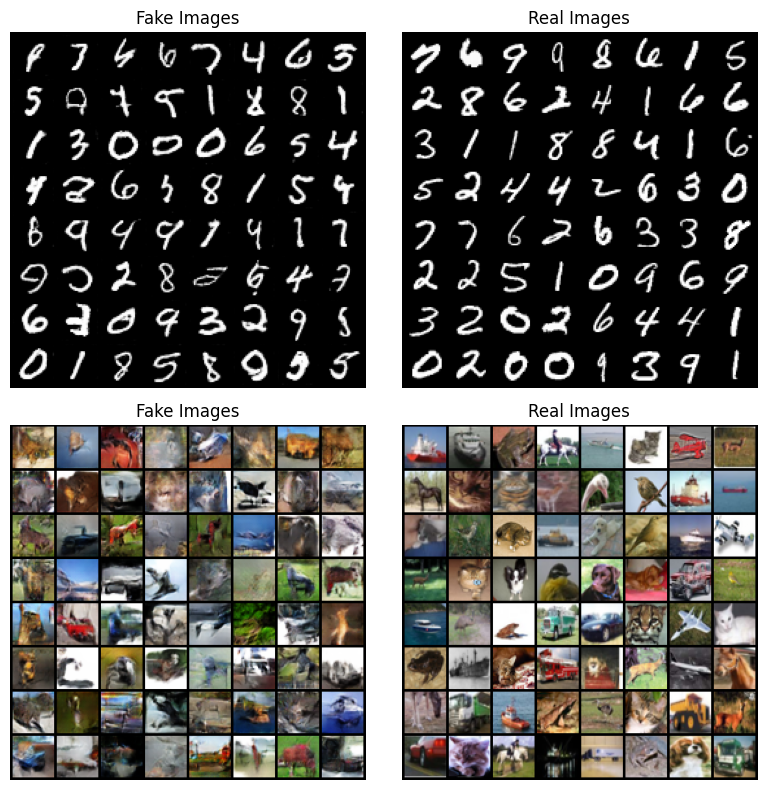

In [ ]:
plt.figure(figsize=(8, 8))


def sample_and_compare(model, dataloader, row):
    model.eval()
    real_batch = next(iter(dataloader))

    fake_images = model.generate(
        torch.randn(64, config.z_dim, 1, 1, device=config.device)
    ).cpu()

    plt.subplot(2, 2, row * 2 - 1)
    plt.imshow(make_grid(fake_images, nrow=8, normalize=True).permute(1, 2, 0))
    plt.axis("off")
    plt.title("Fake Images")

    plt.subplot(2, 2, row * 2)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(
        make_grid(real_batch[0].cpu()[:64], nrow=8, normalize=True).permute(1, 2, 0)
    )


sample_and_compare(model, mnist_dataloader, 1)
sample_and_compare(model2, cifar10_dataloader, 2)
plt.tight_layout()
plt.show()